In [39]:
%config Completer.use_jedi = False

In [40]:
import numpy as np 
import pandas as pd
import random
import os
import glob as gb
import cv2

import seaborn as sns 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import  layers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, RandomContrast, RandomTranslation, RandomRotation, RandomFlip, Rescaling
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score


from tensorflow.keras.optimizers import Adam

In [41]:
# Set seeds to make the experiment more reproducible.

def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

In [42]:
# Define some parameters for the data loader:
BATCH_SIZE = 32
IMG_DIMENSIONS  = (256, 256)

In [43]:
training_path = "/kaggle/input/paddy-disease-classification/train_images"
testing_path = "/kaggle/input/paddy-disease-classification/test_images"

In [44]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    training_path,
    validation_split = 0.2,
    subset="training",
    seed = 123,
    image_size = IMG_DIMENSIONS,
    batch_size = BATCH_SIZE)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.


In [45]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    training_path,
    validation_split = 0.2,
    subset="validation",
    seed = 123,
    image_size = IMG_DIMENSIONS,
    batch_size = BATCH_SIZE)

Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [46]:
# We can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
n_classes = len(class_names)
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [47]:
labels = {'normal':0 ,'blast':1,'hispa':2,'dead_heart':3,'tungro':4,'brown_spot':5 , 'downy_mildew':6 ,
          'bacterial_leaf_blight':7 , 'bacterial_leaf_streak':8 ,'bacterial_panicle_blight':9 }

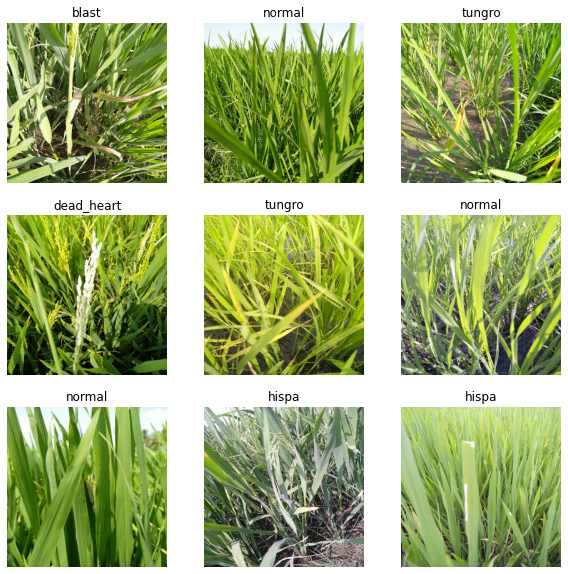

In [48]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Let's Make some Data Augmentation

In [49]:
data_augmentation = Sequential([
   RandomRotation(factor = 0.1),
   RandomFlip('horizontal'),
   RandomTranslation(height_factor = 0.1, width_factor = 0.1),
   RandomContrast(factor = 0.2),
])

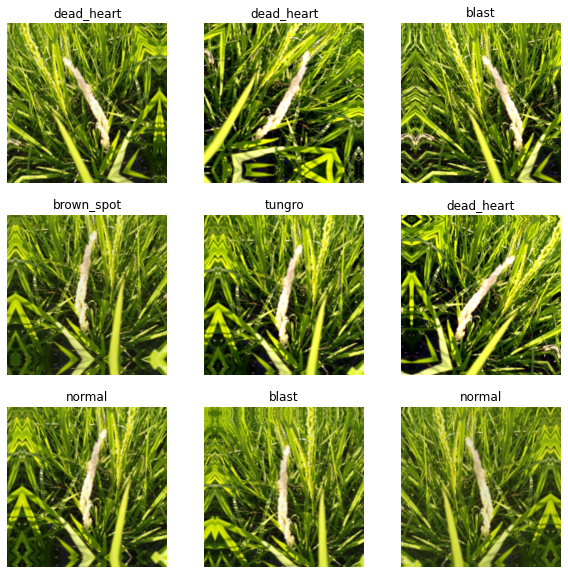

In [50]:
for image, labels in train_ds.take(1):
    plt.figure(figsize = (10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [51]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare_dataset(ds):
    def input_preprocess(image, label):
        label = tf.one_hot(label, n_classes)
        return image, label
    ds = ds.map(input_preprocess, num_parallel_calls = AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size = AUTOTUNE)
    return ds

In [52]:
train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)

# Model Creation

In [53]:
def create_model(n_classes, fine_tune = 0):
    
    inputs = layers.Input(shape = (256, 256, 3))
    x = Rescaling(1.0/255)(inputs)
    
#     x = data_augmentation(x)
    Resnet_base = ResNet50(include_top = False, weights='imagenet',
                           input_shape=(256, 256, 3),
                           pooling='avg', classes=10)
    
    # Freeze the pretrained weights and Rebuild the top layers
    if fine_tune > 0:
        for layer in Resnet_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in Resnet_base.layers:
            layer.trainable = False

    x = Resnet_base(x, training = False)
    x = layers.BatchNormalization()(x)
    
    initializer = tf.keras.initializers.GlorotUniform()
    
    x = tf.keras.layers.Dense(256, kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer = initializer, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = layers.Dense(n_classes, kernel_initializer = initializer, activation = 'softmax', name = 'pred')(x)

    # Compile
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer = Adam(learning_rate = 1e-3), 
        loss = tf.keras.losses.CategoricalCrossentropy(), 
        metrics = ['accuracy'])
    
    return model



In [54]:
model = create_model(10, 2)

In [55]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
pred (Dense)                 (None, 10)                2570

In [57]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    mode='auto', 
    restore_best_weights=True)

In [58]:
model_history = model.fit(
    train_ds, 
    validation_data = val_ds, 
    batch_size = 32, 
    epochs = 50,
    callbacks =[early_stop, checkpoint])

Epoch 1/50
261/261 [==============================] - 39s 135ms/step - loss: 2.0135 - accuracy: 0.4148 - val_loss: 2.0876 - val_accuracy: 0.4089
Epoch 2/50
261/261 [==============================] - 23s 90ms/step - loss: 1.5650 - accuracy: 0.5543 - val_loss: 1.5863 - val_accuracy: 0.5896
Epoch 3/50
261/261 [==============================] - 24s 92ms/step - loss: 1.3909 - accuracy: 0.6177 - val_loss: 1.3363 - val_accuracy: 0.6564
Epoch 4/50
261/261 [==============================] - 23s 90ms/step - loss: 1.2913 - accuracy: 0.6548 - val_loss: 1.2223 - val_accuracy: 0.6958
Epoch 5/50
261/261 [==============================] - 23s 89ms/step - loss: 1.2028 - accuracy: 0.6918 - val_loss: 1.1750 - val_accuracy: 0.7203
Epoch 6/50
261/261 [==============================] - 23s 90ms/step - loss: 1.1480 - accuracy: 0.7101 - val_loss: 1.1334 - val_accuracy: 0.7333
Epoch 7/50
261/261 [==============================] - 23s 90ms/step - loss: 1.0823 - accuracy: 0.7334 - val_loss: 1.1167 - val_accuracy

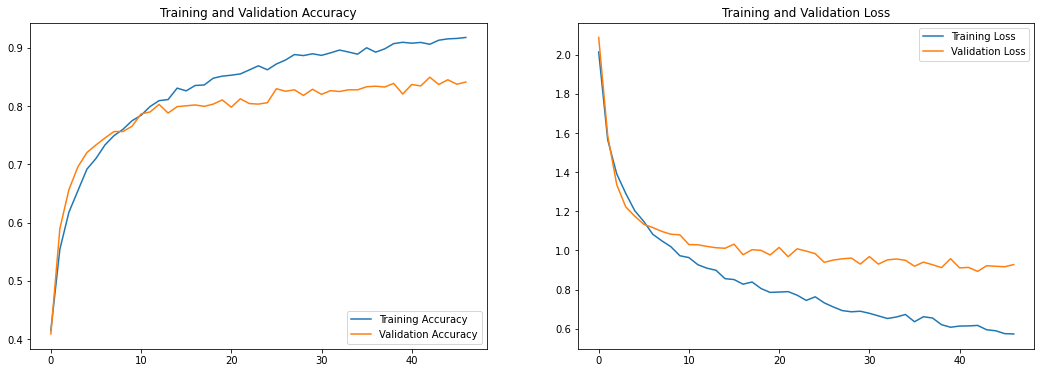

In [59]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()


In [60]:
model.load_weights('./best_model.h5') # initialize the best trained weights

In [61]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    label_mode = None,
    seed = 123,
    image_size = IMG_DIMENSIONS,
    batch_size = BATCH_SIZE,
    shuffle = False)

AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 3469 files belonging to 1 classes.


In [2]:
y_pred =  model.predict(test_ds, batch_size = 32, verbose = 1)
y_pred.shape

NameError: name 'model' is not defined

In [ ]:
y_pred_classes = y_pred.argmax(axis = 1)
y_pred_classes.shape

In [ ]:
y_classes_names = [class_names[x] for x in y_pred_classes]

In [ ]:
predictions = pd.read_csv('/kaggle/input/paddy-disease-classification/sample_submission.csv')
predictions['label'] = y_classes_names
predictions.to_csv('submission.csv', index = False)